<a href="https://colab.research.google.com/github/paranoidandroid2124/AIFFEL_quest_rs/blob/main/Exploration/ex02/first_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import xgboost
import lightgbm
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge

# 로컬 경로
path_temp = "C:/Users/양자/Desktop/Hun_Works/practices/kagglekr_pricing/data"
train_path = join(path_temp, 'train.csv')
test_path = join(path_temp, 'test.csv')

# CSV 읽기
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.info()

# colum들 중에서 불필요하다고 생각되는 애들을 지워보자
## 너무 한 값에 몰려있거나 그런 것들만 제했음
del train['id']
del train['view']
del train['waterfront']
del train['yr_renovated']
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

del test['id']
del test['view']
del test['waterfront']
del test['yr_renovated']
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

"""
대안으로 시도해 본 전처리 삭제는 다음과 같은데,
결국 평가값이 나빠지는 결과만 낳았다.
del train['id']
del train['date']
del train['sqft_living15']
del train['sqft_lot15']
"""

#=========================================================
# (2) Target / Feature 분리
#---------------------------------------------------------
y = train['price']  # price를 타겟으로
del train['price']  # train엔 price 빼준다

# 시각화를 잠깐 해보자 (sqft_lot15)
plt.figure()
sns.countplot(data=train, x='sqft_lot15')
plt.title("Countplot of sqft_lot15 - 그냥 궁금해서 그려봄")
plt.show()

# price 분포도 한 번 보자
plt.figure()
sns.kdeplot(data=y)
plt.title("Original Price Distribution")
plt.show()

# 로그 변환 (오른쪽 꼬리 긴 애들을 좀 편하게 다루기 위해)
y = np.log1p(y)

plt.figure()
sns.kdeplot(data=y)
plt.title("Log1p Transformed Price Distribution")
plt.show()

#=========================================================
# (3) 모델 평가 함수 & 모델 리스트
#---------------------------------------------------------
def rmse(y_test, y_pred):
    """
    RMSE 함수 정의.
    음... 사실 sqrt(mse) 해주는 거지.
    """
    return np.sqrt(mean_squared_error(y_test, y_pred))

random_state = 2025

# 주요 모델들
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost_model = XGBRegressor(random_state=random_state)
lightgbm_model = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost_model, lightgbm_model, rdforest]

def get_scores(models, train, y):
    """
    여러 모델에 대해 동일한 train_test_split으로 나눠서
    fit -> predict -> rmse 계산해 주는 간단한 함수.
    """
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(
            train, y,
            random_state=random_state,
            test_size=0.2
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

score_result = get_scores(models, train, y)
print("초기 모델별 RMSE:\n", score_result)

#=========================================================
# (4) GridSearch로 하이퍼파라미터 탐색 (샘플)
#---------------------------------------------------------
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    """
    GridSearchCV를 활용해서 파라미터 튜닝을 도와주는 함수.
    scoring은 MSE에 -를 붙인 neg_mean_squared_error 써서,
    RMSLE 계산하려면 sqrt(-score) 해줘야 함!
    """
    grid_model = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=verbose,
        n_jobs=n_jobs
    )
    grid_model.fit(train, y)

    # 결과를 예쁘게 DataFrame으로 뽑아주자
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    score_df = pd.DataFrame(score, columns=['score'])
    results = pd.DataFrame(params)
    results['score'] = score_df
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

# GBoost 예시
## 여기 시간 많이잡아먹어서 일단 주석처리
"""
model = gboost
param_grid = {
    'learning_rate': [0.01, 0.2],
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [5, 10],
}
ans1 = my_GridSearch(model, train, y, param_grid)
print("GradientBoosting GridSearch 결과 (상위 1개):\n", ans1.iloc[0])

#=========================================================
# (5) LightGBM, XGBoost도 잠깐만 탐색
#---------------------------------------------------------
model = lightgbm_model
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [-1, 5],
    'num_leaves': [15, 31],
}
ans2 = my_GridSearch(model, train, y, param_grid)
print("LightGBM GridSearch 결과 (상위 1개):\n", ans2.iloc[0])

model = xgboost_model
param_grid = {
    'n_estimators': [10, 50, 200],
    'max_depth': [20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': [0.75, 1.0],
}
ans3 = my_GridSearch(model, train, y, param_grid)
print("XGBoost GridSearch 결과 (상위 1개):\n", ans3.iloc[0])
"""
#=========================================================
# (6) 최적 파라미터로 예측해보기
#---------------------------------------------------------
"""
GridSearch 결과를 바탕으로 각 모델에 파라미터를 세팅해서 fit 후,
test 데이터를 predict하자. 그리고 np.expm1으로 되돌린다(로그변환을 풀어주는 거).
"""
# GradientBoosting
model = GradientBoostingRegressor(
    learning_rate=0.2,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
    n_estimators=50,
    random_state=2025
)
model.fit(train, y)
y_pred1 = model.predict(test)
y_pred1 = np.expm1(y_pred1)

# LightGBM
model = LGBMRegressor(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    num_leaves=31,
    random_state=2025
)
model.fit(train, y)
y_pred2 = model.predict(test)
y_pred2 = np.expm1(y_pred2)

# XGBoost
model = XGBRegressor(
    max_depth=20,
    colsample_bytree=1.0,
    min_child_weight=4,
    gamma=10,
    n_estimators=200,
    random_state=2025
)
model.fit(train, y)
y_pred3 = model.predict(test)
y_pred3 = np.expm1(y_pred3)

#=========================================================
# (7) 모델 스태킹(Blending) 예시
#---------------------------------------------------------
"""
조금 더 복잡해 보이는 부분. Blending해서 최종 예측을 하려는 것.
'메타 모델'로 Ridge를 쓴다.
"""
def stack_and_predict(models, train, y, test):
    """
    1) train/val 나누기
    2) 각 모델로 학습 후 validation, test 예측
    3) 예측 결과를 합쳐서 meta_X_train, meta_X_test 생성
    4) Ridge로 학습 (meta_model)
    5) 최종 예측 -> expm1으로 로그 변환 풀기
    """
    X_train, X_val, y_train, y_val = train_test_split(
        train, y,
        test_size=0.2,
        random_state=2025
    )

    # 일단 개별 모델들 학습
    for m in models:
        m.fit(X_train, y_train)

    # validation, test 예측
    val_preds = [m.predict(X_val) for m in models]
    test_preds = [m.predict(test) for m in models]

    # column_stack으로 합침
    meta_X_train = np.column_stack(val_preds)
    meta_X_test = np.column_stack(test_preds)

    # 메타 모델은 Ridge
    meta_model = Ridge()
    meta_model.fit(meta_X_train, y_val)

    # 최종 예측(로그 -> exp 변환)
    meta_y_test_pred = meta_model.predict(meta_X_test)
    final_prediction = np.expm1(meta_y_test_pred)
    return final_prediction

model1 = GradientBoostingRegressor(
    learning_rate=0.2,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
    n_estimators=50,
    random_state=2025
)
model2 = LGBMRegressor(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    num_leaves=31,
    random_state=2025
)
model3 = XGBRegressor(
    max_depth=20,
    colsample_bytree=1.0,
    min_child_weight=4,
    gamma=10,
    n_estimators=200,
    random_state=2025
)

final_prediction = stack_and_predict([model1, model2, model3], train, y, test)

#=========================================================
# (8) 최종 예측 결과 저장
#---------------------------------------------------------

submission_path = join(path_temp, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = final_prediction
submission_csv_path = join(path_temp, 'submission.csv')
submission.to_csv(submission_csv_path, index=False)

print("[PRT 1] 최종 예측 결과를 여기다 저장했음:", submission_csv_path)

#=========================================================
# (9) 회고(Reflection) 및 결과 & 실행 플로우 간단 설명
#---------------------------------------------------------
"""
[결과]:
- 전처리로 데이터 죽이지 않을 경우 11.2만, 위의 코드처럼 죽일경우 캐글 평가수치 13.9만 에잉
- 무슨 일이 있어도 11.2만 밑으로 안내려간다
[회고(Reflection)]
- 더 자세히 EDA해서 의미 있는 피처가 있는지 확인했으면 좋았을 것 같다.
- 로그 변환해서 타겟 분포가 좀 편해진 건 괜찮았는데,
  expm1으로 되돌릴 때 굉장히 큰 값이 튀어나올 수도 있어서
  그 부분은 조심해야 한다.
- 모델 스태킹의 메타 모델로 Ridge만 썼는데, 다른 것도 시도해보면 좋다.
- GridSearch 파라미터 후보 많으면 진짜 시간 오래 걸린다.
  나중엔 Bayesian Optimization 같은 것도 고려해볼 수 있겠지.

[실행 플로우 그림(텍스트 대체)]
(1) CSV 로드 -> (2) 불필요 열 제거, date 변환 -> (3) 타겟 로그 변환 -> (4) 다양한 모델 fit + RMSE
-> (5) GridSearch로 하이퍼파라미터 탐색 -> (6) 최적 모델로 test 예측 -> (7) 스태킹 시도 -> (8) 최종 CSV 저장
여기까지가 전체 플로우!

[디버깅 기록]
- XGB에서 min_samples_split, min_samples_leaf를 쓰면 에러 났었음.
  XGBoost는 별도 파라미터(min_child_weight 같은) 써야 하더라고.
- learning_rate를 0.2로 했더니 가끔 과적합이 우려되긴 함.
  파라미터 더 줄여가며 교차검증을 좀 더 꼼꼼히 해야 할 듯.
"""


![image.png](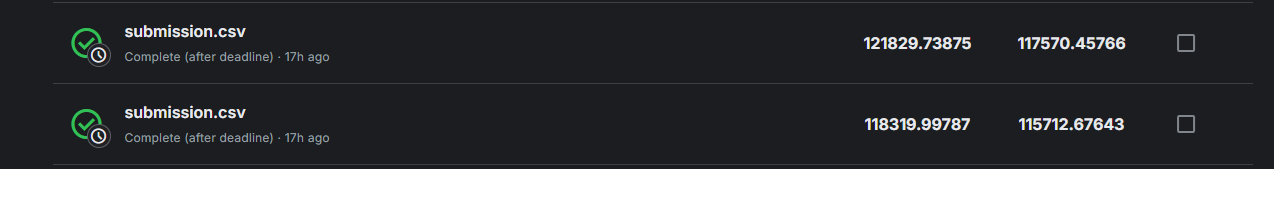)